In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [21]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In [24]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
list('00000')
for binarystring in bitstrings:
    z = np.array(list(binarystring), dtype=int) # is a list of integer representing the current binary string
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


In [25]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    print(Q)
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.32306662 -10.        ]]
[[-10.          19.7365809   19.7365809    5.42015853   5.42015853]
 [ 19.7365809  -10.          20.67626392   0.17675796   0.85604541]
 [ 19.7365809   20.67626392 -10.           0.85604541   0.17675796]
 [  5.42015853   0.17675796   0.85604541 -10.           0.32306662]
 [  5.42015853   0.85604541   0.17675796   0.3

In [26]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

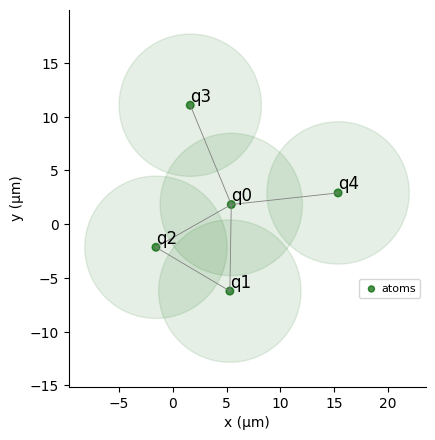

In [ ]:
qubits = {'q0': np.array([5.43591935, 1.83221016]),
 'q1': np.array([ 5.30433156, -6.2289737 ]),
 'q2': np.array([-1.57590666, -2.14702291]),
 'q3': np.array([ 1.61714433, 11.07433973]),
 'q4': np.array([15.37762057,  2.91043984])}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [97]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)


for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [98]:
import time
def quantum_loop(parameters):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ch0", "rydberg_global")

    t_list = seq.declare_variable("t_list", size=LAYERS)
    s_list = seq.declare_variable("s_list", size=LAYERS)


    for t, s in zip(t_list, s_list):
        pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
        pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

        seq.add(pulse_1, "ch0")
        seq.add(pulse_2, "ch0")

    seq.measure("ground-rydberg")


    
    params = np.array(parameters)

    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    assigned_seq.draw()
    s_readable = assigned_seq.to_abstract_repr(
    json_dumps_options={"indent": 1},
    seq_name="qaoa_seq",
    )
    with open(f"qaoa2{time.time()}.json", "w") as f:
        f.write(s_readable)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [ ]:
LAYERS = 2
np.random.seed(151)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}
# optimal_array = [[9.34167118, 2.27130768],
#  [8.57625465 ,2.70184433],
#  [8.46303954, 2.45161533],
#  [9.11268288 ,2.22450115],
#  [9.31664128, 2.447587  ],
#  [8.85598306, 1.64633822],
#  [9.97253034, 1.72514458],
#  [9.38000773, 1.45700094],
#  [8.97176167, 1.58918132],
#  [8.78742231, 2.26445045],
#  [8.68820589, 1.18535679],
#  [9.46854535, 1.86786162],
#  [9.1088774 , 1.8637817 ],
#  [8.12832316, 1.98956513],
#  [8.80580329, 1.85219168],
#  [9.48645651, 1.62631664],
#  [8.37422211, 1.85474882],
#  [8.36012661, 2.80727353],
#  [9.07311243 ,2.89151002],
#  [9.07366547, 2.0058863 ]]

# [[10.22251347,  2.49894049],
#  [ 9.2351566,   1.7927563 ],
#  [ 7.17415459,  3.10382428],
#  [ 8.54410561,  2.49094206]]
example_dict = quantum_loop(optimal_array)
#np.r_[guess["t"], guess["s"]])
example_dict


ValueError: cannot reshape array of size 40 into shape (2,2)

In [91]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

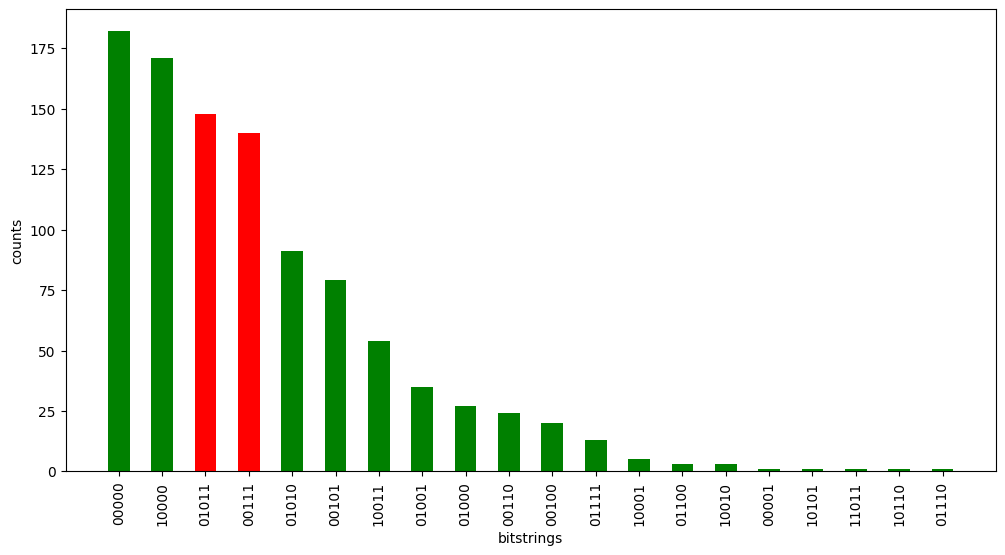

In [92]:
plot_distribution(example_dict)

In [16]:
np.linspace(1, 10, 5)

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [ ]:
import numpy as np
from scipy.optimize import minimize
from pulser import Pulse, Sequence, Register
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import ConstantWaveform
from pulser_simulation import QutipEmulator

# ------------------------------------------------------------------
# 1.  Problem instance (your 5-by-5 QUBO)
# ------------------------------------------------------------------
Q = np.array(
    [[-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
     [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
     [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
     [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
     [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0]]
)

# ------------------------------------------------------------------
# 2.  An embedding of the QUBO onto five atoms
#     (use whatever layout you already found – this one is the one
#     in the Pulser tutorial)
# ------------------------------------------------------------------
qubits = {'q0': np.array([5.43591935, 1.83221016]),
 'q1': np.array([ 5.30433156, -6.2289737 ]),
 'q2': np.array([-1.57590666, -2.14702291]),
 'q3': np.array([ 1.61714433, 11.07433973]),
 'q4': np.array([15.37762057,  2.91043984])}
reg = Register(qubits)
# ------------------------------------------------------------------
# 3.  “Quantum part” → build a fresh Sequence for every
#     (t1 … tp , s1 … sp) proposal
# ------------------------------------------------------------------
LAYERS = 20                 # same “p” as in your PennyLane code
SAMPLE_SHOTS = 2_000       # shots used to estimate ⟨H_Q⟩

def build_sequence(params):
    """
    params = [t1 … tp , s1 … sp]  (length = 2*p)
    ti, si are in µs   (as in the original notebook).
    """
    t_params, s_params = np.split(params, 2)

    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")

    for t_i, s_i in zip(t_params, s_params):
        # durations must be integers in ns → multiply by 1000
        dur_t = int(1_000 * t_i)
        dur_s = int(1_000 * s_i)

        pulse_t = Pulse.ConstantPulse(dur_t, 1.0, 0.0, 0.0)   # Ω ≠ 0, Δ = 0
        pulse_s = Pulse.ConstantPulse(dur_s, 0.0, 1.0, 0.0)   # Ω = 0, Δ ≠ 0

        seq.add(pulse_t, "ising")
        seq.add(pulse_s, "ising")

    seq.measure("ground-rydberg")
    return seq

# ------------------------------------------------------------------
# 4.  Cost function  ⟨zᵀ Q z⟩  estimated from sampled bitstrings
# ------------------------------------------------------------------
def bitstring_cost(bitstr):
    z = np.fromiter(bitstr, dtype=int)        # 0/1 → |g⟩/|r⟩
    return z @ Q @ z

def sequence_cost(params):
    seq = build_sequence(params)
    sim = QutipEmulator.from_sequence(seq, sampling_rate=0.01)
    res = sim.run()
    counts = res.sample_final_state(N_samples=SAMPLE_SHOTS)

    # empirical expectation value
    total = sum(counts.values())
    return sum(bitstring_cost(b)*k for b, k in counts.items()) / total

# ------------------------------------------------------------------
# 5.  Classical optimisation (exactly like your PennyLane loop)
# ------------------------------------------------------------------
np.random.seed(123)
x0 = np.r_[np.random.uniform(8,10,LAYERS),   # initial t_i
           np.random.uniform(1, 3, LAYERS)]  # initial s_i

opt = minimize(sequence_cost,
               x0=x0,
               method="Nelder-Mead",          # derivative-free
               options={"maxiter": 60, "fatol": 1e-3})

print("Best cost found:", opt.fun)
print("Optimised (t, s) µs :", opt.x.reshape(2, LAYERS).T)


c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 2698 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 2700 ns.
  self._add(pulse, channel, protocol)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 8453 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 8456 ns.
  self._add(pulse, channel, protocol)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 9102 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 9104 ns.
  self._add(pulse, channel, protocol)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 2222 ns is not a multiple of the channel's clock period (4 ns). It w

Best cost found: -16.29914702277
Optimised (t, s) µs : [[9.34167118 2.27130768]
 [8.57625465 2.70184433]
 [8.46303954 2.45161533]
 [9.11268288 2.22450115]
 [9.31664128 2.447587  ]
 [8.85598306 1.64633822]
 [9.97253034 1.72514458]
 [9.38000773 1.45700094]
 [8.97176167 1.58918132]
 [8.78742231 2.26445045]
 [8.68820589 1.18535679]
 [9.46854535 1.86786162]
 [9.1088774  1.8637817 ]
 [8.12832316 1.98956513]
 [8.80580329 1.85219168]
 [9.48645651 1.62631664]
 [8.37422211 1.85474882]
 [8.36012661 2.80727353]
 [9.07311243 2.89151002]
 [9.07366547 2.0058863 ]]


In [80]:
from pennylane import qaoa, AdamOptimizer
steps = 900
depth = LAYERS
optimizer = AdamOptimizer()
params = np.r_[np.random.uniform(8,10,LAYERS),
           np.random.uniform(1, 3, LAYERS)]
# Optimization loop
for i in range(steps):
    params = optimizer.step(sequence_cost, params)
    if i% 10 == 1:
        print(f'step {i} out of {steps}')

print("Optimal Parameters:")
print(params)
print("Optimal Energy:", sequence_cost(params))

c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 1441 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 1444 ns.
  self._add(pulse, channel, protocol)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 2799 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 2800 ns.
  self._add(pulse, channel, protocol)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 9271 ns is not a multiple of the channel's clock period (4 ns). It was rounded up to 9272 ns.
  self._add(pulse, channel, protocol)
c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulser\sequence\sequence.py:1281: UserWarning: A duration of 9262 ns is not a multiple of the channel's clock period (4 ns). It w

step 1 out of 900
step 11 out of 900
step 21 out of 900
step 31 out of 900
step 41 out of 900
step 51 out of 900
step 61 out of 900
step 71 out of 900
step 81 out of 900
step 91 out of 900
step 101 out of 900
step 111 out of 900
step 121 out of 900
step 131 out of 900
step 141 out of 900
step 151 out of 900
step 161 out of 900
step 171 out of 900
step 181 out of 900
step 191 out of 900
step 201 out of 900
step 211 out of 900
step 221 out of 900
step 231 out of 900
step 241 out of 900
step 251 out of 900
step 261 out of 900
step 271 out of 900
step 281 out of 900
step 291 out of 900
step 301 out of 900
step 311 out of 900
step 321 out of 900
step 331 out of 900
step 341 out of 900
step 351 out of 900
step 361 out of 900
step 371 out of 900
step 381 out of 900
step 391 out of 900
step 401 out of 900
step 411 out of 900
step 421 out of 900
step 431 out of 900
step 441 out of 900
step 451 out of 900
step 461 out of 900
step 471 out of 900
step 481 out of 900
step 491 out of 900
step 501 ou